# See if there is any coorelation between the release of econ data and stock market performance in the short term
## - for econ data
## - for earnings/dividends for established cos

# Notes

## Iterations
- 1. MVP: Get predictions working for single variable (e.g. predicting close price of a single day based on the earnigns call for that day)
- 2. Include for other variables (e.g. previous earnings, predicted earnings, acctual earnings)
- 3. Include more variables
    - Econ indicators
    - Secotr performance
    - Technical indicators (moving averages, volume, momentum, etc)
- 4. Include news & sentiment
- 5. Make real-time
- 5. Make an interface
- 6. Include some generative AI/nat-lang features for ease of use
    - Querries, automanage money based on perameters/requests

## Recourses
- Alphavantage (https://www.alphavantage.co/documentation/)
    - Has free API and a lot of data: Sentiment, technical indicators, economic indicators, fundamental data (earnings, etc)
    - github wrapper for AV: (https://github.com/RomelTorres/alpha_vantage/tree/develop?tab=readme-ov-file)
        - examples: (https://github.com/RomelTorres/av_example/tree/master) - NOTE: they are old 
    - Predicting Stock Prces w/ RNNs from the AV website (https://www.alphavantage.co/stock-prediction-deep-neural-networks-lstm/)
    - another simple lstm predictor (https://github.com/easonlai/stock_forecast_lstm/blob/main/stock_forecast_lstm_msft.ipynb)
    - all GitHub repositories for alpha-vantage (https://github.com/topics/alpha-vantage?o=asc&s=stars)

- Github might have something

In [14]:
%matplotlib inline
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.sectorperformance import SectorPerformances
from alpha_vantage.cryptocurrencies import CryptoCurrencies
import matplotlib
import matplotlib.pyplot as plt
import os
import pandas as pd
print("setup complete")

setup complete


In [15]:
ALPHAVANTAGE_API_KEY = 'N7EN1EHTWSGEIUB2'

# Initial tests following RomelTorres wrapper

In [21]:
ts = TimeSeries(key=ALPHAVANTAGE_API_KEY, output_format='pandas')
data, meta_data = ts.get_intraday(symbol='MSFT',interval='1min', outputsize='full')
# We can describe it
data.describe()

,1. open,2. high,3. low,4. close,5. volume
count,15250.000000,15250.000000,15250.000000,15250.000000,1.525000e+04
mean,415.204407,415.382400,414.981092,415.218132,2.696117e+04
std,8.484701,8.393317,8.694096,8.393147,2.877530e+05
min,303.214000,398.770000,303.214000,387.423000,1.000000e+00
25%,407.405500,407.600000,407.201250,407.411250,1.390000e+02
50%,415.130000,415.260000,415.007500,415.140000,1.223000e+03
75%,420.890000,420.990000,420.790750,420.910000,2.517950e+04
max,442.915000,447.229000,431.090000,431.170000,1.933452e+07


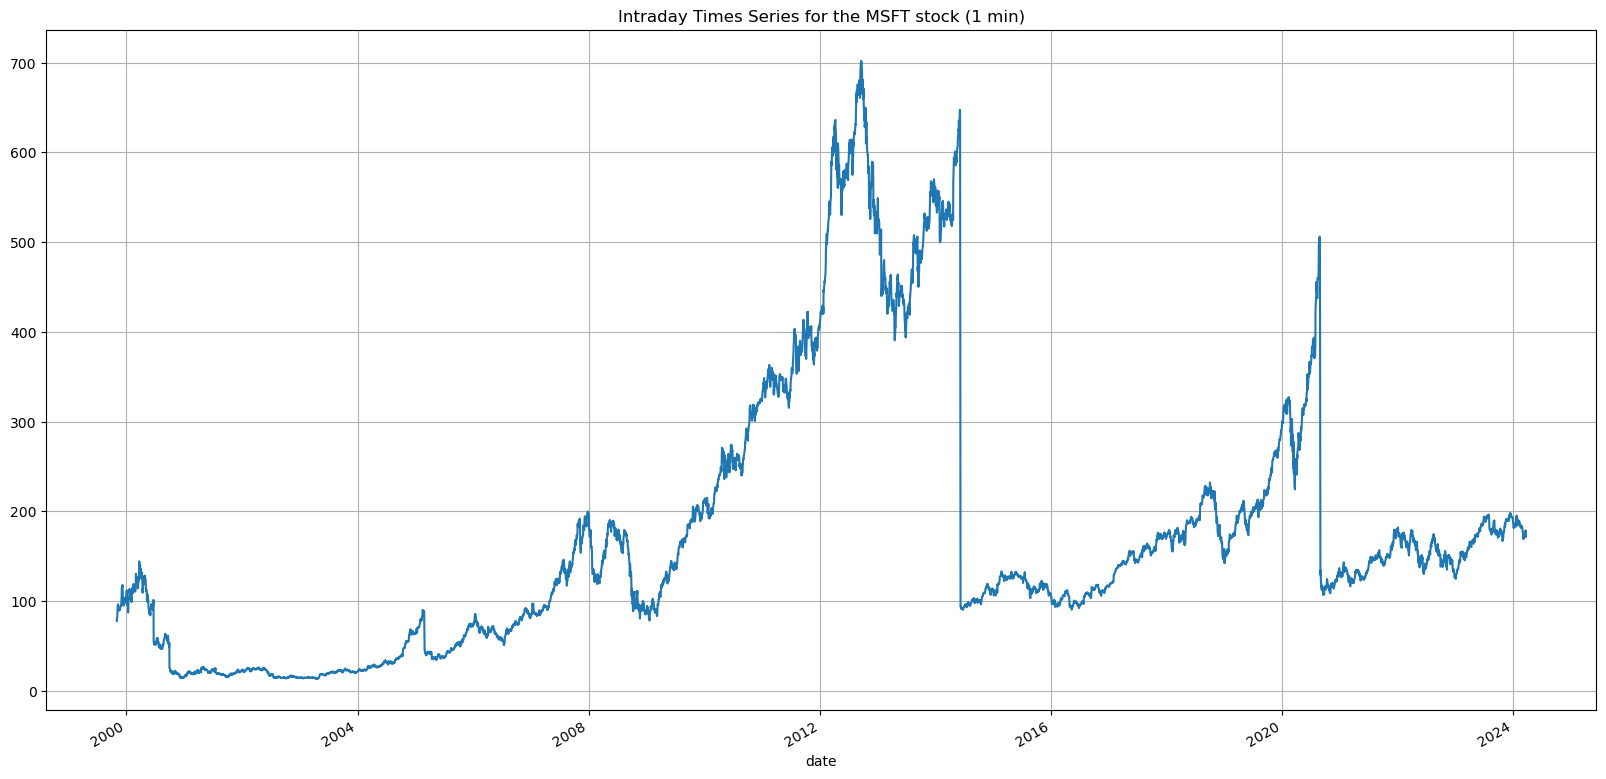

In [35]:
data.describe()
data['4. close'].plot()
plt.title('Intraday Times Series for the MSFT stock (1 min)')
plt.grid()
plt.show()

In [ ]:
meta_data

{'1. Information': 'Intraday (1min) open, high, low, close prices and volume',
 '2. Symbol': 'MSFT',
 '3. Last Refreshed': '2024-03-22 19:59:00',
 '4. Interval': '1min',
 '5. Output Size': 'Full size',
 '6. Time Zone': 'US/Eastern'}

/var/folders/jp/6l9fcsfs0dq5_695_52tn60r0000gn/T/ipykernel_4680/1780190624.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop('5. volume',1)


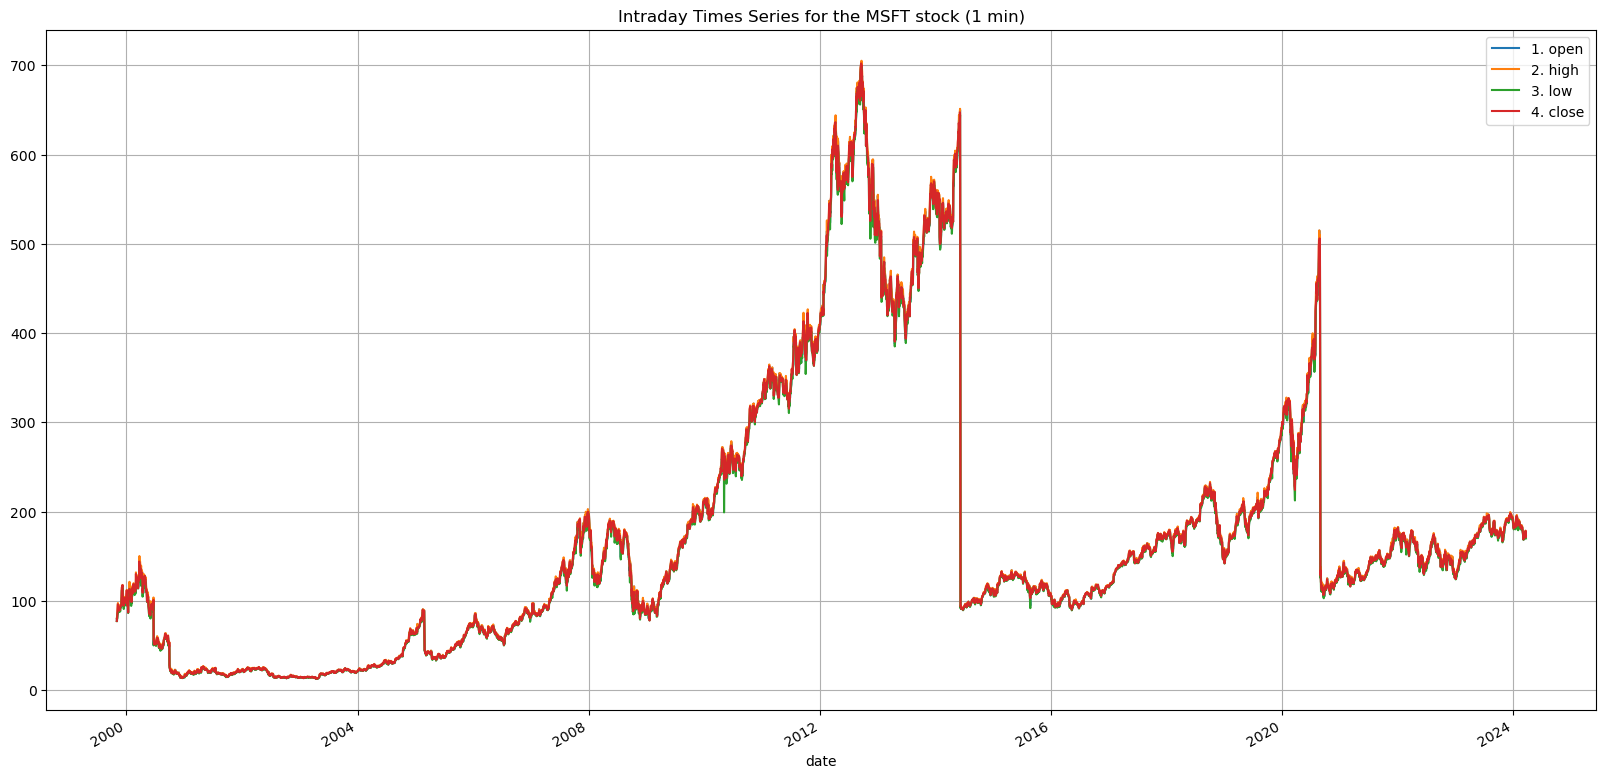

In [36]:
data = data.drop('5. volume',1)
data.plot()
plt.title('Intraday Times Series for the MSFT stock (1 min)')
plt.grid()
plt.show()

In [32]:
# Initialize the TimeSeries object with your API key
ts = TimeSeries(key=ALPHAVANTAGE_API_KEY, output_format='pandas')

# Get Apple stock data
data, meta_data = ts.get_daily(symbol='AAPL', outputsize='full')

# Convert the index to datetime
data.index = pd.to_datetime(data.index)

# Filter data for the specified date range
start_date = '2023-01-01'
end_date = '2023-12-31'
filtered_data = data.loc[(data.index >= start_date) & (data.index <= end_date)]

# Print the filtered data (open and close columns)
filtered_data[['1. open', '4. close']]

,1. open,4. close
date,,
2023-12-29,193.900,192.53
2023-12-28,194.140,193.58
2023-12-27,192.490,193.15
2023-12-26,193.610,193.05
2023-12-22,195.180,193.60
...,...,...
2023-01-09,130.465,130.15
2023-01-06,126.010,129.62
2023-01-05,127.130,125.02


# Predictive model following AV Academy course
- https://www.alphavantage.co/stock-prediction-deep-neural-networks-lstm/

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from alpha_vantage.timeseries import TimeSeries 

print("setup complete")

setup complete


## Data and config setup

In [2]:
config = {
    "alpha_vantage": {
        "key": 'demo', #change Key
        "symbol": "IBM",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "xticks_interval": 90, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, ###### since we are only using 1 feature, close price #####
        "num_lstm_layers": 2, ##### Change when adding features #####
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

Number data points 6137 from 1999-11-01 to 2024-03-22


/var/folders/jp/6l9fcsfs0dq5_695_52tn60r0000gn/T/ipykernel_7101/3929400272.py:29: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None, which='major', axis='y', linestyle='--')


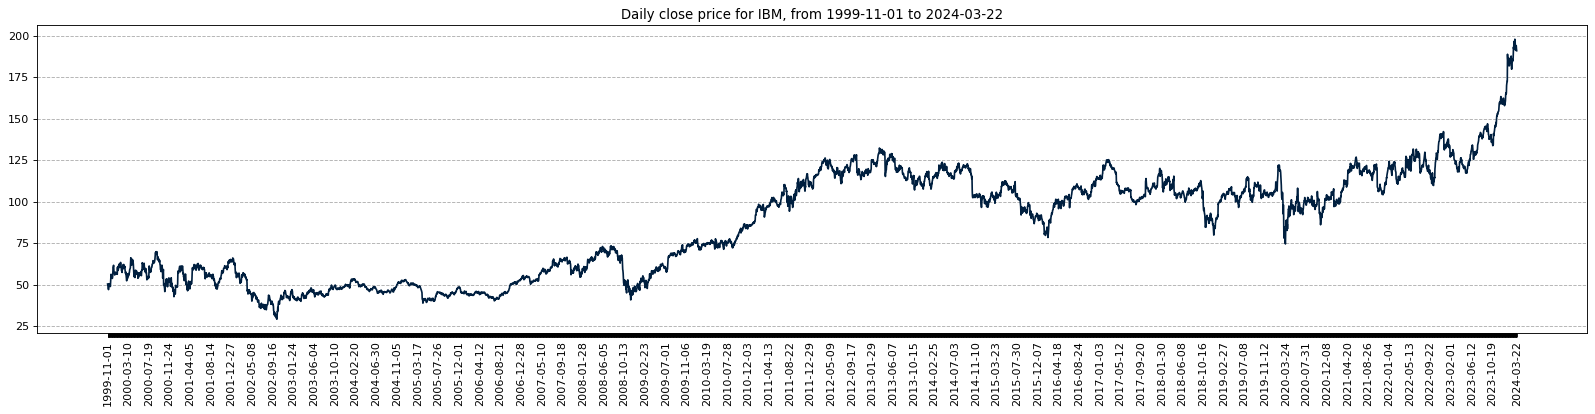

In [3]:
def download_data(config):
    ts = TimeSeries(key='demo') #Change key: may need to change data I'm getting too (premium)
    data, meta_data = ts.get_daily_adjusted(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])

    data_date = [date for date in data.keys()]
    data_date.reverse()

    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points", num_data_points, display_date_range)

    return data_date, data_close_price, num_data_points, display_date_range

data_date, data_close_price, num_data_points, display_date_range = download_data(config)

# plot

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.show()

## Normalization 

In [4]:
# Normalize the scale of data to improve gradient optimization for LSTM
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

# normalize
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)

## Data Splitting

/var/folders/jp/6l9fcsfs0dq5_695_52tn60r0000gn/T/ipykernel_7101/3773715183.py:48: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None, which='major', axis='y', linestyle='--')


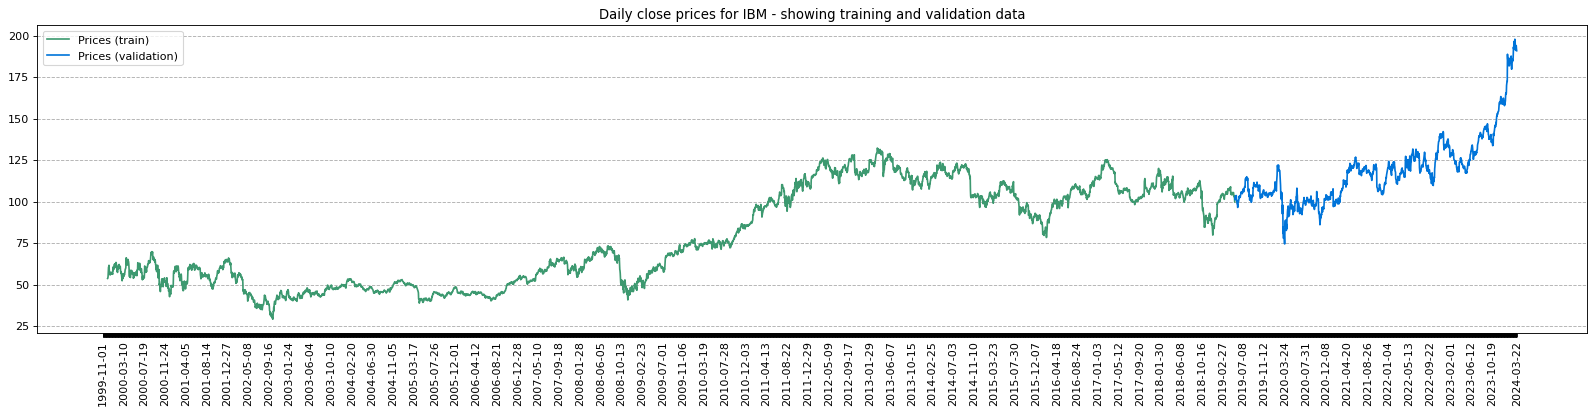

In [5]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    return output[:-1], output[-1]


def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x[window_size:]
    return output

data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

# split dataset

split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]
data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]

# prepare data for plotting

to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)

to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(data_y_train)
to_plot_data_y_val[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(data_y_val)

to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

## plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close prices for " + config["alpha_vantage"]["symbol"] + " - showing training and validation data")
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

## Model formation

In [6]:
# Load the split data for pytorch
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)


Train data shape (4893, 20, 1) (4893,)
Validation data shape (1224, 20, 1) (1224,)


In [7]:
# Model fromation
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

In [8]:
# Training the model
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))

Epoch[1/100] | loss train:0.056712, test:0.066599 | lr:0.010000
Epoch[2/100] | loss train:0.011255, test:0.033876 | lr:0.010000
Epoch[3/100] | loss train:0.009186, test:0.027275 | lr:0.010000
Epoch[4/100] | loss train:0.008610, test:0.020612 | lr:0.010000
Epoch[5/100] | loss train:0.008441, test:0.034843 | lr:0.010000
Epoch[6/100] | loss train:0.008135, test:0.039996 | lr:0.010000
Epoch[7/100] | loss train:0.007583, test:0.018265 | lr:0.010000
Epoch[8/100] | loss train:0.007577, test:0.016219 | lr:0.010000
Epoch[9/100] | loss train:0.007548, test:0.015530 | lr:0.010000
Epoch[10/100] | loss train:0.007785, test:0.018382 | lr:0.010000
Epoch[11/100] | loss train:0.007094, test:0.008361 | lr:0.010000
Epoch[12/100] | loss train:0.007562, test:0.008603 | lr:0.010000
Epoch[13/100] | loss train:0.007472, test:0.010463 | lr:0.010000
Epoch[14/100] | loss train:0.007049, test:0.026500 | lr:0.010000
Epoch[15/100] | loss train:0.007249, test:0.015506 | lr:0.010000
Epoch[16/100] | loss train:0.00722

## Evaluation

/var/folders/jp/6l9fcsfs0dq5_695_52tn60r0000gn/T/ipykernel_7101/3240130280.py:50: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None, which='major', axis='y', linestyle='--')


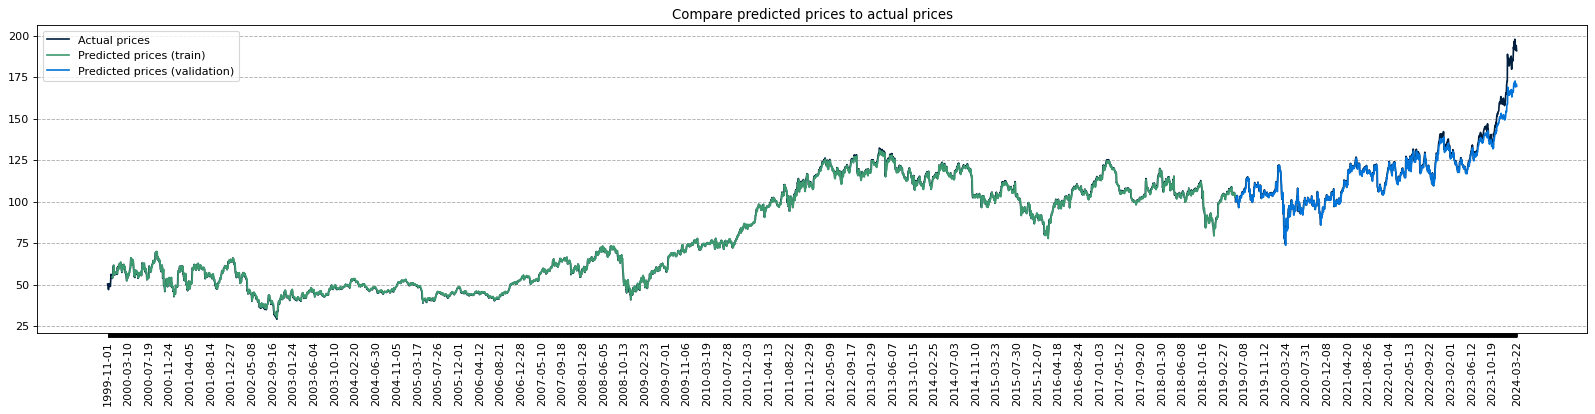

In [9]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

# prepare data for plotting

to_plot_data_y_train_pred = np.zeros(num_data_points)
to_plot_data_y_val_pred = np.zeros(num_data_points)

to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

# plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Compare predicted prices to actual prices")
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

/var/folders/jp/6l9fcsfs0dq5_695_52tn60r0000gn/T/ipykernel_7101/3136694754.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None, which='major', axis='y', linestyle='--')


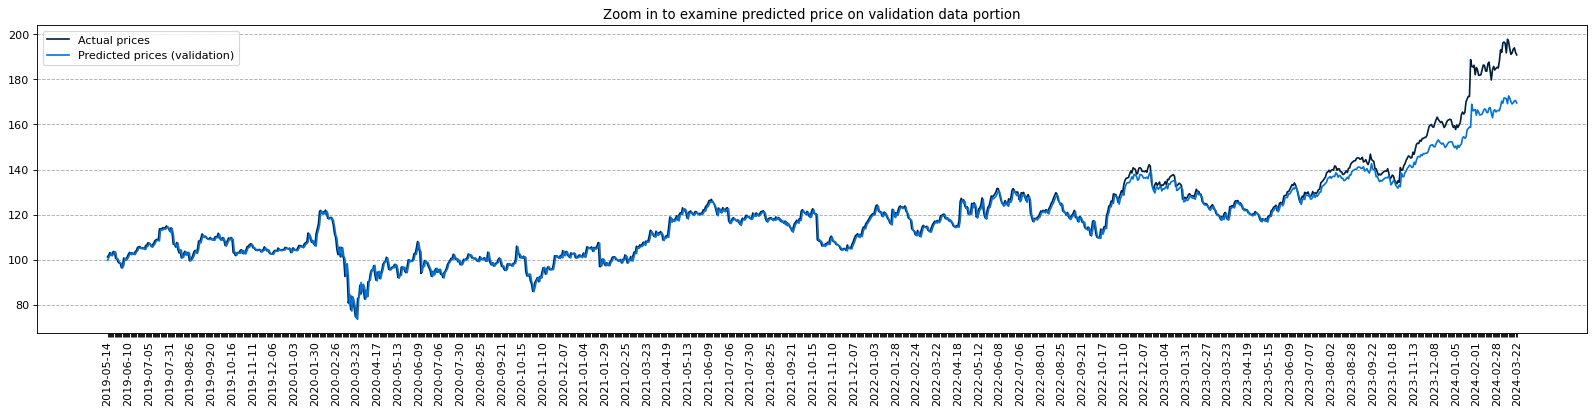

In [10]:
# prepare data for plotting the zoomed in view of the predicted prices (on validation set) vs. actual prices

to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)
to_plot_predicted_val = scaler.inverse_transform(predicted_val)
to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]

# plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Zoom in to examine predicted price on validation data portion")
xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
xs = np.arange(0,len(xticks))
plt.xticks(xs, xticks, rotation='vertical')
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

/var/folders/jp/6l9fcsfs0dq5_695_52tn60r0000gn/T/ipykernel_7101/177214878.py:36: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None, which='major', axis='y', linestyle='--')


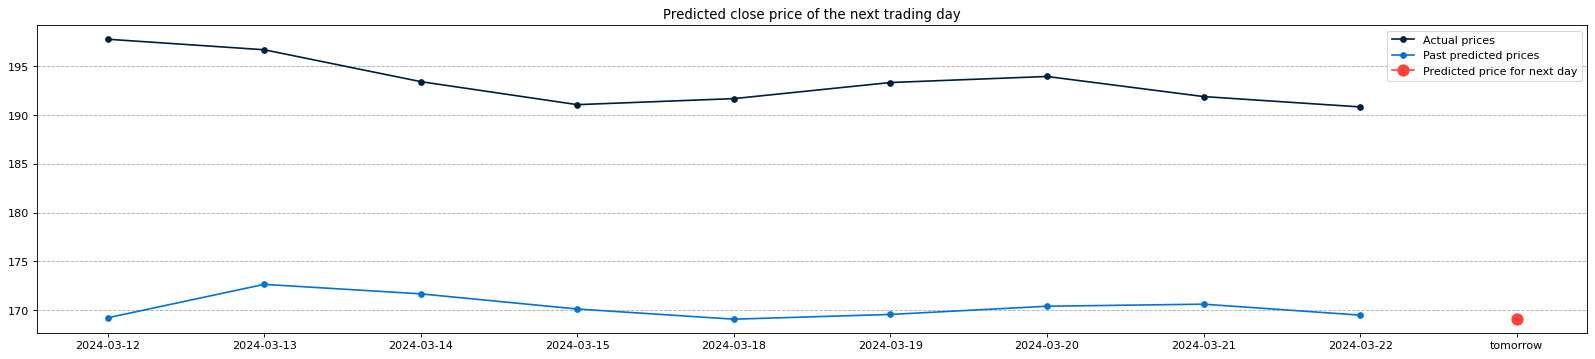

Predicted close price of the next trading day: 169.07


In [11]:
# predict the closing price of the next trading day

model.eval()

x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
prediction = model(x)
prediction = prediction.cpu().detach().numpy()

# prepare plots

plot_range = 10
to_plot_data_y_val = np.zeros(plot_range)
to_plot_data_y_val_pred = np.zeros(plot_range)
to_plot_data_y_test_pred = np.zeros(plot_range)

to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val)[-plot_range+1:]
to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val)[-plot_range+1:]

to_plot_data_y_test_pred[plot_range-1] = scaler.inverse_transform(prediction)

to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

# plot

plot_date_test = data_date[-plot_range+1:]
plot_date_test.append("tomorrow")

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
plt.title("Predicted close price of the next trading day")
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

print("Predicted close price of the next trading day:", round(to_plot_data_y_test_pred[plot_range-1], 2))


# Gettting other data
- Helpful stackoverflow (https://stackoverflow.com/questions/48071949/how-to-use-the-alpha-vantage-api-directly-from-python)

Follow the format found below for the data config - it's essentially calling the data from Alpha Vantage and the the functions, etc. are in that specific format so that AV can understand it. The data sent back will be in .json format unless specified as CSV. The functions and kwargs are put in dictionary form below for some reason. The docs aren't great for usability, look at the above stack overflow for how to format the queries to tickle AV just right. NOTE: 25 querries goes fast.

Next steps;
    - Finagle the news/sentiment - looks like I can get a straight value for a specific stock(s) to concat on
    - Figure out how to either 1.) Querry multiple different data sets at once for a given stock (e.g. ernings, sentiment, price, etc. in the same querry) or, 2.) Learn how to concat the different data - most likely on the date, imputations will be an issue, plus that is querry heavy compared to option 1 
    - Config the RNNs to include the other data types in the training to predict the price
    

In [19]:
import requests

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=EARNINGS&symbol=IBM&apikey=demo'
r = requests.get(url)
data = r.json()

earnings_data = data['quarterlyEarnings']

# Convert to DataFrame
df = pd.DataFrame(earnings_data)

df.head()

,fiscalDateEnding,reportedDate,reportedEPS,estimatedEPS,surprise,surprisePercentage
0,2023-12-31,2024-01-24,3.87,3.78,0.09,2.381
1,2023-09-30,2023-10-25,2.2,2.13,0.07,3.2864
2,2023-06-30,2023-07-19,2.18,2.01,0.17,8.4577
3,2023-03-31,2023-04-19,1.36,1.26,0.1,7.9365
4,2022-12-31,2023-01-25,3.6,3.6,0,0


In [39]:
# Get Earnings for MSFT
API_URL = "https://www.alphavantage.co/query" 
symbol = 'MSFT'

data = { "function": "EARNINGS", 
        "symbol": symbol,
        "outputsize" : "full",
        "datatype": "json", 
        "apikey": ALPHAVANTAGE_API_KEY } 

response = requests.get(API_URL, data) 
response_json = response.json() # maybe redundant

earnings_data = response_json['quarterlyEarnings']

# Convert to DataFrame
earnings_df = pd.DataFrame(earnings_data)
earnings_df.head()

,fiscalDateEnding,reportedDate,reportedEPS,estimatedEPS,surprise,surprisePercentage
0,2023-12-31,2024-01-30,2.93,2.78,0.15,5.3957
1,2023-09-30,2023-10-24,2.99,2.65,0.34,12.8302
2,2023-06-30,2023-07-25,2.69,2.55,0.14,5.4902
3,2023-03-31,2023-04-25,2.45,2.23,0.22,9.8655
4,2022-12-31,2023-01-24,2.32,2.29,0.03,1.31


In [48]:
# Get econ indicator (CPI)
API_URL = "https://www.alphavantage.co/query" 
symbol = 'MSFT'

data = { "function": "CPI", 
        "interval": "monthly",
        "outputsize" : "full",
        "datatype": "json", 
        "apikey": ALPHAVANTAGE_API_KEY } 

response = requests.get(API_URL, data) 
response_json = response.json()

cpi_data = response_json['data']

# Convert to DataFrame
cpi_df = pd.DataFrame(cpi_data)
cpi_df.head()

,date,value
0,2024-02-01,310.326
1,2024-01-01,308.417
2,2023-12-01,306.746
3,2023-11-01,307.051
4,2023-10-01,307.671


In [63]:
# Get news/sentiment
API_URL = "https://www.alphavantage.co/query" 
symbol = 'MSFT'

data = { "function": "NEWS_SENTIMENT",
        "tickers": 'COIN',
        "topics":['earnings','economy_macro'],
        'time_from': '20220410T0130',
        'limit': '50',
        "datatype": "json", 
        "apikey": ALPHAVANTAGE_API_KEY } 

sentiment_response = requests.get(API_URL, data) 
sentiment_json = sentiment_response.json()

sentiment_data = sentiment_json['feed']

# Convert to DataFrame
sentiment_df = pd.DataFrame(sentiment_data)
sentiment_df.head()




KeyError: 'feed'

In [64]:
sentiment_json


{'Information': 'Thank you for using Alpha Vantage! Our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.'}